In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import torch
from turboflow.dataloaders import Turbo2D_simple, load_turbo2D_simple_numpy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

from turboflow.dataloaders import Turbo2D_simple

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch

In [3]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


In [4]:
device = tch.get_device()
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Torch running on: cuda:0
Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [13]:
from turboflow.models.rbf import RBFNet

# model (RFF + MLP + RBF)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
hout = 2
ncnt = 128
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [hout]

rbfnet = RBFNet('RBFNet', mlp_layers, fft_nfeat, fft_scale, ncnt, nout)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rbfnet.to(device)
rbfnet.fit(trainloader, epochs=1000) # we are not afraid to overfit the data, this is coord-based MLP!

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 0.533716
Epoch: 200, Loss: 0.034835
Epoch: 300, Loss: 0.013828
Epoch: 400, Loss: 0.003832
Epoch: 500, Loss: 0.001486
Epoch: 600, Loss: 0.000859
Epoch: 700, Loss: 0.000597
Epoch: 800, Loss: 0.000451
Epoch: 900, Loss: 0.000359
Epoch: 1000, Loss: 0.000295
Done with Training
Final error: 0.00029533630004152656


(4096, 2)


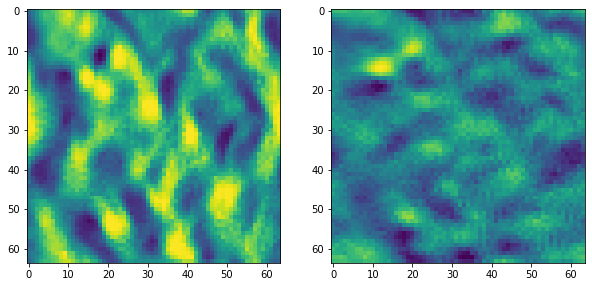

(65536, 2)


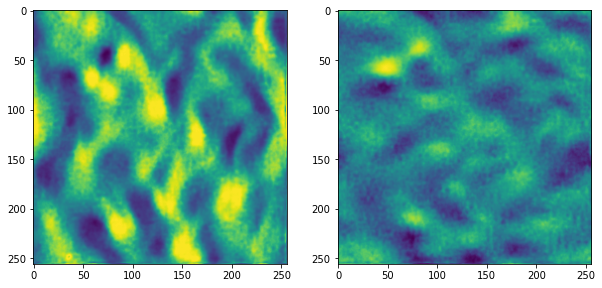

In [16]:
ngrid = 64
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

rbfnet.eval().to(device)
pred = rbfnet(x)

Urbf_lr = pred.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(Urbf_lr.reshape(ngrid,ngrid,2)[:,:,0])
plt.subplot(122)
plt.imshow(Urbf_lr.reshape(ngrid,ngrid,2)[:,:,1])
plt.show()


# TEST upsampling
ngrid = 256
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

rbfnet.eval().to(device)
pred = rbfnet(x)

Urbf = pred.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(Urbf.reshape(ngrid,ngrid,2)[:,:,0])
plt.subplot(122)
plt.imshow(Urbf.reshape(ngrid,ngrid,2)[:,:,1])
plt.show()

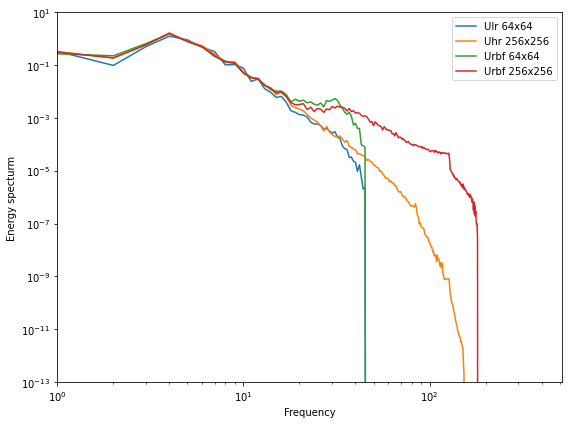

In [17]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urbf_lr.reshape(L,L,2)[:,:,0]))), 
                         phy.powerspec(Urbf_lr.reshape(L,L,2)[:,:,0]), label='Urbf 64x64')
axs.loglog(np.arange(len(phy.powerspec(Urbf.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urbf.reshape(H,H,2)[:,:,0]), label='Urbf 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

(128, 3)
(128, 2)


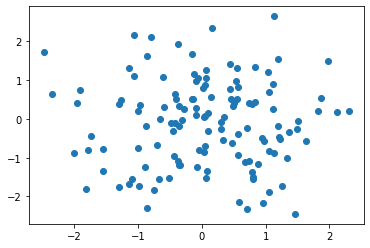

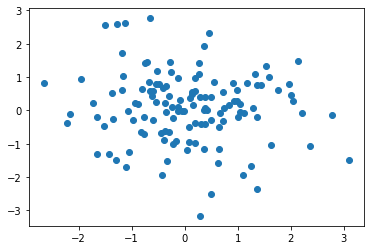

In [11]:
centroids = rbfnet.rbf.centres.detach().cpu().numpy()
alphas = rbfnet.rbf.alphas.detach().cpu().numpy()
print(centroids.shape)
print(alphas.shape)

fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
plt.scatter(centroids[:,0],centroids[:,1])
plt.show()

plt.scatter(alphas[:,0],alphas[:,1])
plt.show()

In [30]:
from turboflow.models.rbf import RBFNet

# model (RFF + MLP + RBF)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
hout = 8
ncnt = 64
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [hout]

rbfnet = RBFNet('RBFNet', mlp_layers, fft_nfeat, fft_scale, ncnt, nout)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rbfnet.to(device)
rbfnet.fit(trainloader, epochs=3000) # we are not afraid to overfit the data, this is coord-based MLP!

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 1.026294
Epoch: 200, Loss: 1.011338
Epoch: 300, Loss: 1.003086
Epoch: 400, Loss: 0.981582
Epoch: 500, Loss: 0.972394
Epoch: 600, Loss: 0.967892
Epoch: 700, Loss: 0.959513
Epoch: 800, Loss: 0.945747
Epoch: 900, Loss: 0.943000
Epoch: 1000, Loss: 0.933959
Epoch: 1100, Loss: 0.944632
Epoch: 1200, Loss: 0.931148
Epoch: 1300, Loss: 0.927560
Epoch: 1400, Loss: 0.917516
Epoch: 1500, Loss: 0.909307
Epoch: 1600, Loss: 0.911825
Epoch: 1700, Loss: 0.899764
Epoch: 1800, Loss: 0.895355
Epoch: 1900, Loss: 0.887361
Epoch: 2000, Loss: 0.892398
Epoch: 2100, Loss: 0.869138
Epoch: 2200, Loss: 0.861956
Epoch: 2300, Loss: 0.864084
Epoch: 2400, Loss: 0.902558
Epoch: 2500, Loss: 0.861445
Epoch: 2600, Loss: 0.853350
Epoch: 2700, Loss: 0.849562
Epoch: 2800, Loss: 0.862971
Epoch: 2900, Loss: 0.864133
Epoch: 3000, Loss: 0.8

In [29]:
# TEST
ngrid = 256
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

pred = rbfnet(x)
rbfnet.eval().to(device)

Udfrbf = pred.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(Udfrbf.reshape(ngrid,ngrid,2)[:,:,0])
plt.subplot(122)
plt.imshow(Udfrbf.reshape(ngrid,ngrid,2)[:,:,1])
plt.show()

(65536, 2)


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 15.75 GiB total capacity; 13.76 GiB already allocated; 32.19 MiB free; 13.79 GiB reserved in total by PyTorch)

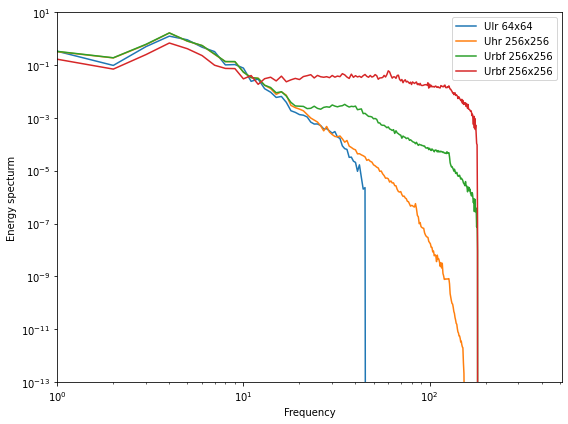

In [25]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urbf.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urbf.reshape(H,H,2)[:,:,0]), label='Urbf 256x256')
axs.loglog(np.arange(len(phy.powerspec(Udfrbf.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Udfrbf.reshape(H,H,2)[:,:,0]), label='Urbf 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()